# Trust Experiments

Here we look at the effect of constant vs. dynamic physician trust in our model. We do this for various initial FPR rates as the relation between final (converged) FPR and the physician trust depends heavily on initial FPR. We'll use `sklearn.datasets.make_classification` to generate the data

In [1]:
import copy
import numpy as np
import pandas as pd
import torch

import seaborn as sns
sns.set()

import matplotlib.pyplot as plt

import sklearn.linear_model as linear_model


from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import importlib
import utils
importlib.reload(utils)

from utils import eval_model, perturb_labels_fp, update_model_conditional_trust, update_model_increasing_trust, make_gaussian_data

In [2]:
def train_update_loop(n_train, n_update, n_test, num_updates, trust_rates, physician_fprs, update_fn, trust_fn, data_fn, seeds):
    seeds = np.arange(seeds)
    fprs = {trust: {physician_fpr: [] for physician_fpr in physician_fprs} for trust in trust_rates}

    for seed in seeds:
        print(seed)
        np.random.seed(seed)
        x_train, y_train, x_update, y_update, x_test, y_test = data_fn(n_train, n_update, n_test)

        model = linear_model.SGDClassifier(max_iter=10000, tol=1e-3, warm_start=True, loss="log")
        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)
        initial_tnr, initial_fpr, initial_fnr, initial_tpr = eval_model(y_test, y_pred)

        for trust in trust_rates:
            for physician_fpr in physician_fprs:
                trusts = trust_fn(trust, num_updates)
                new_model = update_fn(model, x_update, y_update, num_updates, trusts, physician_fpr)

                y_pred = new_model.predict(x_test)
                updated_tnr, updated_fpr, updated_fnr, updated_tpr = eval_model(y_test, y_pred)

                fprs[trust][physician_fpr].append(updated_fpr)
    
    return fprs

In [3]:
def train_update_loop_conditional(n_train, n_update, n_test, num_updates, physician_fpr, update_fn, data_fn, seeds):
    seeds = np.arange(seeds)
    fprs = []
    trust_rates = []

    for seed in seeds:
        print(seed)
        np.random.seed(seed)
        x_train, y_train, x_update, y_update, x_test, y_test = data_fn(n_train, n_update, n_test)

        model = linear_model.SGDClassifier(max_iter=10000, tol=1e-3, warm_start=True, loss="log")
        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)
        initial_tnr, initial_fpr, initial_fnr, initial_tpr = eval_model(y_test, y_pred)

        new_model, rates, trusts = update_fn(model, x_update, y_update, x_test, y_test, num_updates, physician_fpr, intermediate=True)

        fprs.append([initial_fpr] + rates["fpr"])
        trust_rates.append([1 - initial_fpr] + trusts)
    
    return fprs, trust_rates

In [ ]:
def train_update_loop_linear(n_train, n_update, n_test, num_updates, physician_fpr, update_fn, data_fn, seeds):
    seeds = np.arange(seeds)
    fprs = []
    trust_rates = []

    for seed in seeds:
        print(seed)
        np.random.seed(seed)
        x_train, y_train, x_update, y_update, x_test, y_test = data_fn(n_train, n_update, n_test)

        model = linear_model.SGDClassifier(max_iter=10000, tol=1e-3, warm_start=True, loss="log")
        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)
        initial_tnr, initial_fpr, initial_fnr, initial_tpr = eval_model(y_test, y_pred)

        new_model, rates, trusts = update_fn(model, x_update, y_update, x_test, y_test, num_updates, physician_fpr, intermediate=True)

        fprs.append([initial_fpr] + rates["fpr"])
        trust_rates.append([1 - initial_fpr] + trusts)
    
    return fprs, trust_rates

In [4]:
def results_to_dataframe(fprs, trust_rates, physician_fprs):
    data = {"fpr": [], "Physician FPR": [], "trust": []}

    for trust in trust_rates:
        for physician_fpr in physician_fprs:
            data["fpr"] += fprs[trust][physician_fpr]
            data["Physician FPR"] += [physician_fpr] * len(fprs[trust][physician_fpr])
            data["trust"] += [trust] * len(fprs[trust][physician_fpr])
            
    return pd.DataFrame(data)

In [5]:
def results_to_dataframe_conditional(fprs, trusts):
    data = {"fpr": [], "trust": [], "num_updates": []}
    
    for i in range(len(fprs)):
        data["fpr"] += fprs[i]
        data["trust"] += trusts[i]
        data["num_updates"] += (np.arange(len(fprs[i]))).tolist()
        
    return pd.DataFrame(data)

In [37]:
def lineplot(data, data_type, trust_type, physician_fprs):
    fig = plt.figure(figsize=(13,9))
#     fig.suptitle("FPR Degeneration, {}, and Physician FPR {} Data".format(trust_type, data_type), fontsize=24)

    ax = fig.add_subplot(111)
    g = sns.lineplot(x="trust", y="fpr", hue="Physician FPR", data=data, legend="full",marker="o", ax=ax, palette="bright")
    ax.set_ylabel("FPR", fontsize=30, labelpad=10.0)
    ax.set_xlabel("Trust", fontsize=30, labelpad=10.0)
    ax.tick_params(axis='both', which='major', labelsize=24)
    ax.tick_params(axis='both', which='minor', labelsize=24)

    ax.set_xlim([0, 1.0])
    ax.set_ylim([0, 0.6])

    legend = ax.legend(title="Clinician\nFPR", title_fontsize=24, labels=physician_fprs, loc="upper right", bbox_to_anchor=(1.15, 1), borderaxespad=0.)
    legend.texts[0].set_size(20)

    fig.show()
    fig.savefig("figures/trust/{}_data_{}.png".format(data_type, trust_type), dpi=600)
    fig.savefig("figures/trust/{}_data_{}.pdf".format(data_type, trust_type))

In [7]:
def logit_from_trust(trust):
    return - np.log((1.0 / trust) - 1)

In [8]:
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

In [9]:
def constant_trust_fn(initial_trust, num_updates):
    return [initial_trust] * num_updates

In [10]:
def linear_trust_fn(initial_trust, num_updates):
    return np.linspace(initial_trust, 1.0, num_updates)

In [11]:
def conditional_trust_fn(initial_trust, num_updates):
    return initial_trust

In [12]:
def exponential_trust_fn(initial_trust, num_updates):
    trust_ub = logit_from_trust(0.9999) / np.log(10.0)
    trust_lb = logit_from_trust(initial_trust) / np.log(10.0)

    trusts = np.logspace(trust_lb, trust_ub, num=num_updates)
    trusts = sigmoid(trusts)
    
    print(trust_ub)
    print(trust_lb)
    
    return trusts

In [13]:
def generate_gaussian_data(n_train, n_update, n_test, noise=0.0, num_features=2):
    m0 = -1
    m1 = 1
    
    s0 = 1
    s1 = 1
    
    p0 = 0.5
    p1 = 1 - p0
    
    x_train, y_train = make_gaussian_data(m0, m1, s0, s1, n_train, p0, p1, features=num_features, noise=noise)

    x_update, y_update = make_gaussian_data(m0, m1, s0, s1, n_update, p0, p1, features=num_features)
    x_test, y_test = make_gaussian_data(m0, m1, s0, s1, n_test, p0, p1, features=num_features)

    return x_train, y_train, x_update, y_update, x_test, y_test

In [14]:
def generate_sklearn_make_classification_data(n_train, n_update, n_test, noise=0.0, num_features=2):
    x, y = make_classification(n_train + n_update + n_test, n_informative=num_features, n_features=num_features, n_classes=2, n_clusters_per_class=2 ,n_redundant=0, flip_y=0, class_sep=1.0)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=n_update + n_test)
    x_update, x_test, y_update, y_test = train_test_split(x_test, y_test, test_size=n_test)
    
    return x_train, y_train, x_update, y_update, x_test, y_test

In [38]:
n_train = 1000
n_update = 10000
n_test = 50000
num_updates = 100

# trust_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# physician_fprs = [0.0, 0.01, 0.025, 0.05, 0.075, 0.1]
trust_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.925, 0.95, 0.975, 0.99]
physician_fprs = [0.0, 0.025, 0.05, 0.075, 0.1, 0.2, 0.3, 0.4]
seeds = 100

In [42]:
data_fns = {"gaussian": generate_gaussian_data}
# update_fns = {"constant_trust": update_model_increasing_trust, "conditional_trust": update_model_conditional_trust, "linearly_increasing_trust": update_model_increasing_trust}
# trust_fns = {"constant_trust": constant_trust_fn, "conditional_trust": conditional_trust_fn, "linearly_increasing_trust": linear_trust_fn}
update_fns = {"constant_trust": update_model_increasing_trust, "linearly_increasing_trust": update_model_increasing_trust}
trust_fns = {"constant_trust": constant_trust_fn, "linearly_increasing_trust": linear_trust_fn}

In [43]:
data_non_temporal = {data_type: {} for data_type in data_fns.keys()}

for data_type, data_fn in data_fns.items():
    for trust_type in update_fns.keys():
        trust_fn = trust_fns[trust_type]
        update_fn = update_fns[trust_type]
        
        temp = train_update_loop(n_train, n_update, n_test, num_updates, trust_rates, physician_fprs, update_fn, trust_fn, data_fn, seeds)
        data_non_temporal[data_type][trust_type] = results_to_dataframe(temp, trust_rates, physician_fprs)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [44]:
sns.set_style("white")

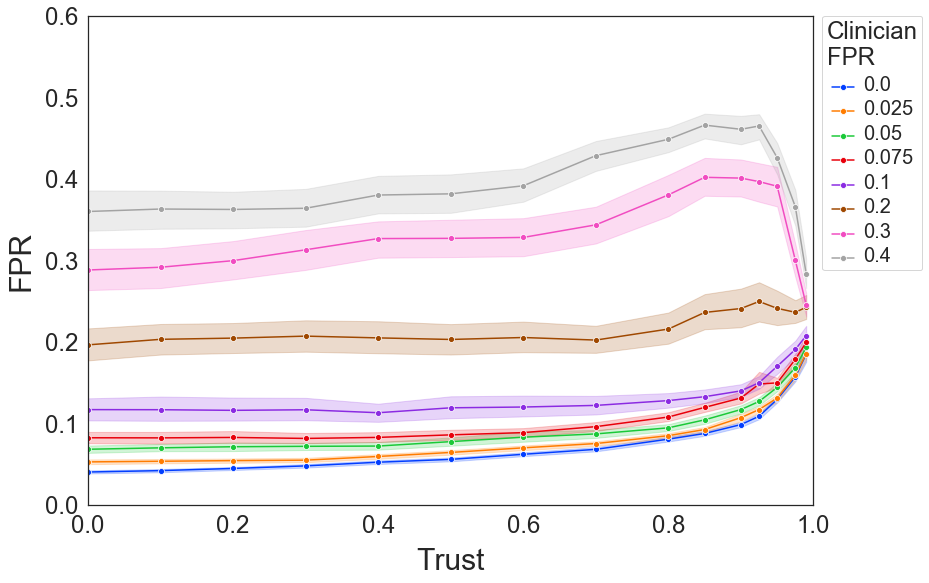

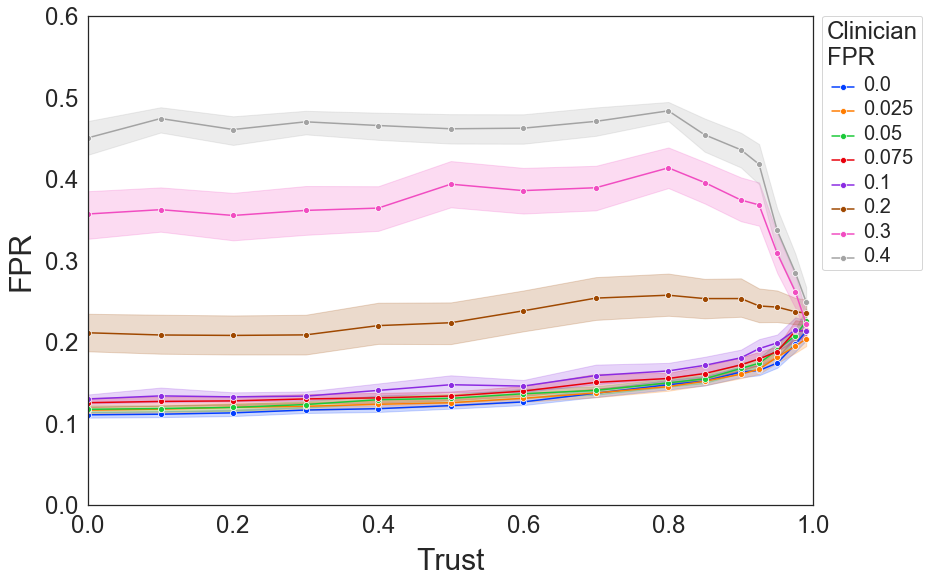

In [45]:
for data_type in data_fns.keys():
    for trust_type in update_fns.keys():
        lineplot(data_non_temporal[data_type][trust_type], data_type, trust_type, physician_fprs)

## Conditional Trust

The plots for conditional trust are tricky since the initial trust is $1 - FPR_{initial}$ and the final trust is $1 - FPR_{final}$, so it's like we need a plot that's temporal in trust

In [30]:
n_train = 1000
n_update = 10000
n_test = 50000
num_updates = 100

# trust_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# physician_fprs = [0.0, 0.01, 0.025, 0.05, 0.075, 0.1]
physician_fpr = 0.05
seeds = 100

In [31]:
data_fn = generate_gaussian_data
update_fn = update_model_conditional_trust

In [32]:
fprs_temporal, trusts_temporal = train_update_loop_conditional(n_train, n_update, n_test, num_updates, physician_fpr, update_fn, data_fn, seeds)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [41]:
data_temporal = results_to_dataframe_conditional(fprs_temporal, trusts_temporal)

In [34]:
sns.set_style("white")
sns.set_palette("bright")

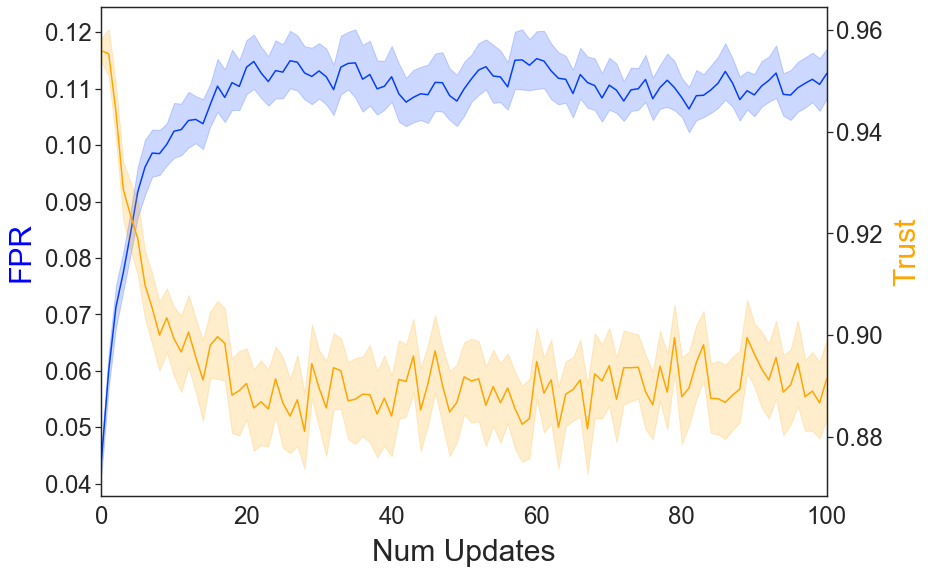

In [36]:
fig = plt.figure(figsize=(13,9))
# fig.suptitle("FPR vs Num Updates (fixed batch size)", fontsize=24)

ax = fig.add_subplot(111)


g = sns.lineplot(x="num_updates", y="fpr", data=data_temporal, ax=ax)
ax.set_ylabel("FPR", fontsize=30, labelpad=10.0, color="blue")
ax.set_xlabel("Num Updates", fontsize=30, labelpad=10.0)

ax.tick_params(axis='both', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=24)

ax.set_xlim([0, num_updates])

ax2 = ax.twinx()

g = sns.lineplot(x="num_updates", y="trust", data=data, ax=ax2, color="orange")
ax2.set_ylabel("Trust", fontsize=30, labelpad=10.0, color="orange")
ax2.set_xlabel("Num Updates", fontsize=30, labelpad=10.0)

ax2.tick_params(axis='both', which='major', labelsize=24)
ax2.tick_params(axis='both', which='minor', labelsize=24)





# legend = g.legend(loc='upper right',  ncol=1, bbox_to_anchor=(1.22, 1), borderaxespad=0., prop={'size':14})

# plt.setp(legend.get_title(),fontsize='xx-small')

# legend.texts[0].set_size(20)



fig.show()
fig.savefig("figures/trust/gaussian_data_conditional_trust.png", dpi=600)
fig.savefig("figures/trust/gaussian_data_conditional_trust.pdf")